In [1]:
import os
import warnings
import sys

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from sklearn import linear_model, preprocessing, metrics, model_selection
import mlflow
import mlflow.sklearn
from mlflow.models.signature import infer_signature
from mlflow.tracking import MlflowClient

import seaborn as sn

if 'inline_rc' not in dir():
    inline_rc = dict(mpl.rcParams)

SEED = 10


# import logging
# logging.basicConfig(level=logging.WARN)
# logger = logging.getLogger(__name__)
np.random.seed(SEED)

In [2]:
# reset matplotlib

mpl.rcParams.update(inline_rc)
font = {'size'   : 14}
mpl.rc('font', **font)
lines = {'linewidth' : 3}
mpl.rc('lines', **lines)

In [2]:
top_features = ['lat','lon','minutes_remaining', 'period', 'playoffs','shot_distance']
dataset_dev = pd.read_csv('../../Data/Raw/dataset_kobe.csv',sep=',')
kobe_target_col = 'shot_made_flag'

dataset_dev = dataset_dev.dropna()

dataset_dev = dataset_dev[top_features + [kobe_target_col]].copy()

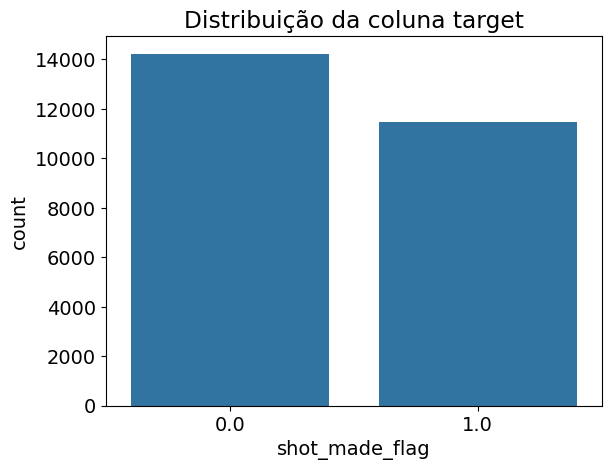

In [4]:
ax = plt.axes()
sn.countplot(x=kobe_target_col, data=dataset_dev, ax=ax);
ax.set_title('Distribuição da coluna target')
plt.show()

Text(0.5, 1.0, 'Latitude e longitude')

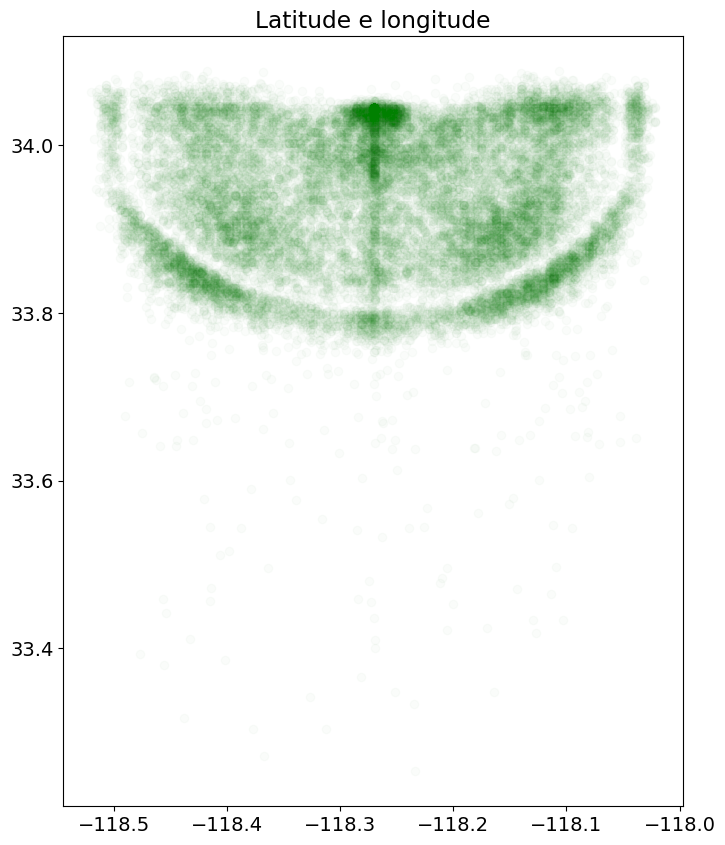

In [5]:
plt.figure(figsize=(8,10))
plt.scatter(dataset_dev.lon, dataset_dev.lat, color='green', alpha=0.02)
plt.title('Latitude e longitude')

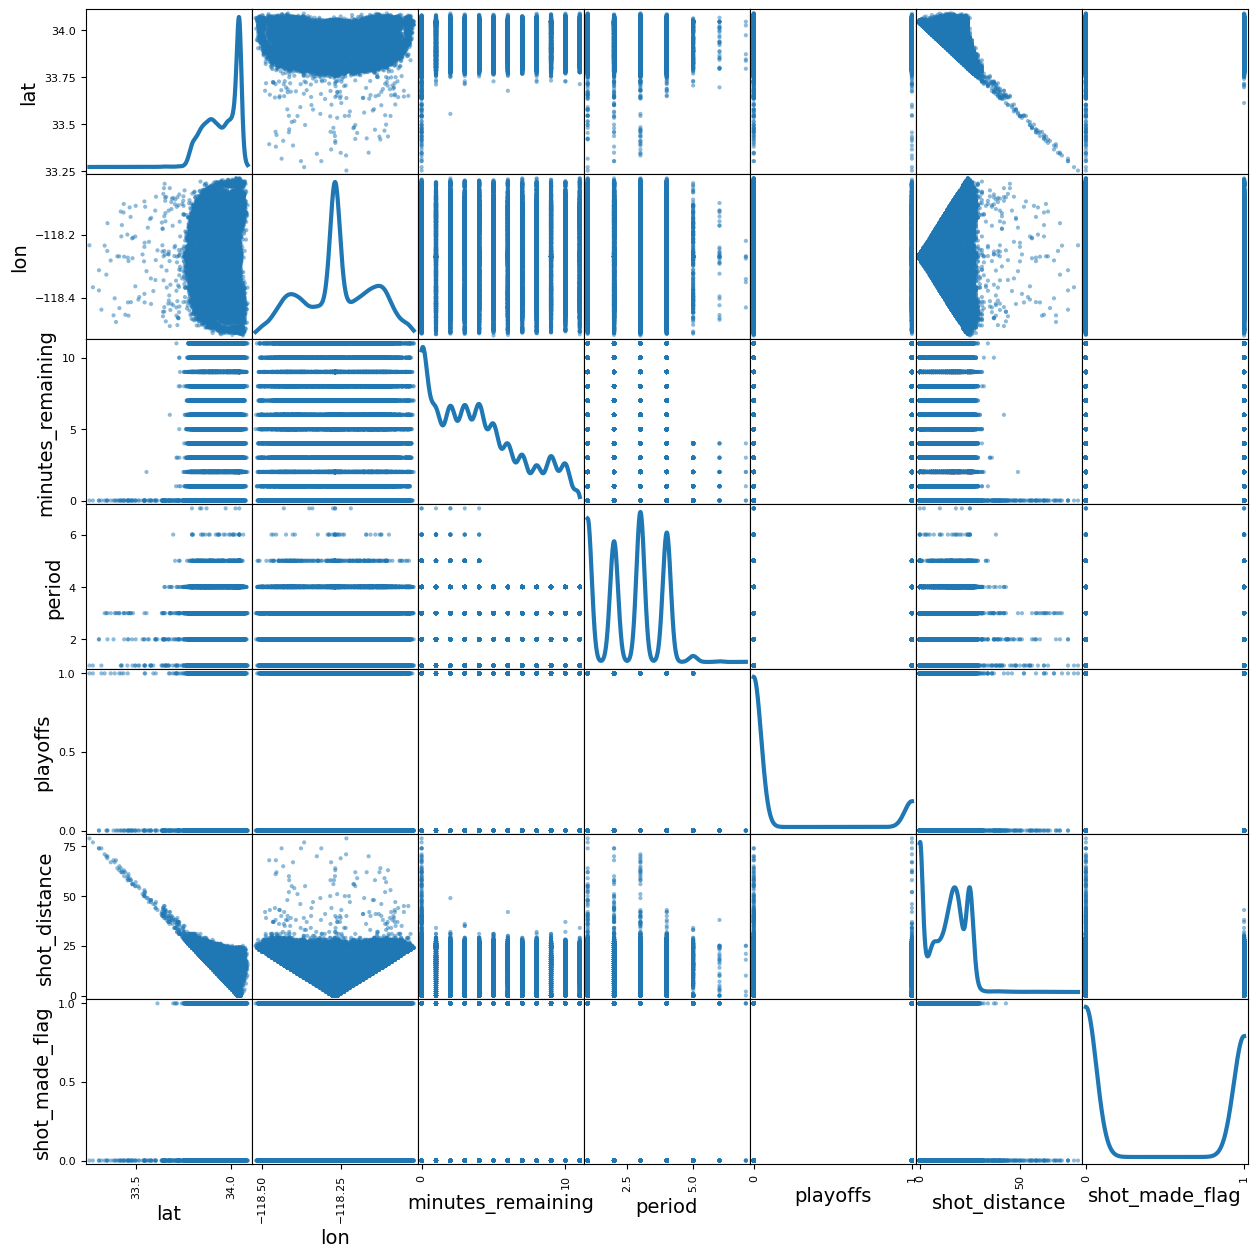

In [6]:
pd.plotting.scatter_matrix(dataset_dev, diagonal='kde', figsize=(15,15));

<Axes: >

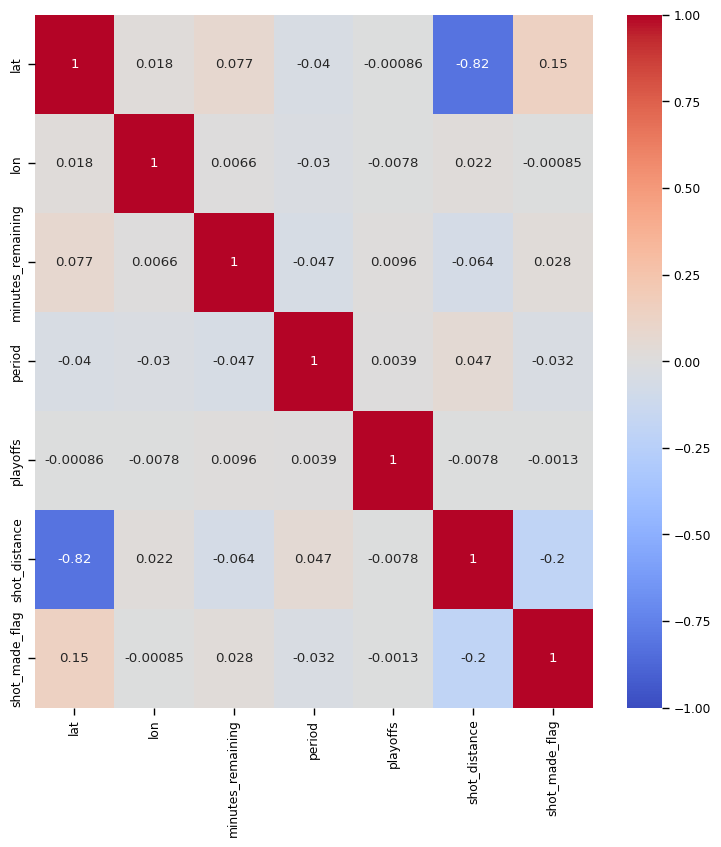

In [7]:
sn.set_context('paper')

fig, ax = plt.subplots(figsize=(9, 9))
sn.heatmap(dataset_dev.corr(), cmap='coolwarm', vmin=-1, vmax=1, annot=True)

In [3]:
# Para usar o sqlite como repositorio
mlflow.set_tracking_uri("sqlite:///mlruns.db")

experiment_name = 'Data Preparation'
experiment = mlflow.get_experiment_by_name(experiment_name)
if experiment is None:
    experiment_id = mlflow.create_experiment(experiment_name)
    experiment = mlflow.get_experiment(experiment_id)
experiment_id = experiment.experiment_id


2024/04/14 16:18:07 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2024/04/14 16:18:07 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Running upgrade  -> 451aebb31d03, add metric step
INFO  [alembic.runtime.migration] Running upgrade 451aebb31d03 -> 90e64c465722, migrate user column to tags
INFO  [alembic.runtime.migration] Running upgrade 90e64c465722 -> 181f10493468, allow nulls for metric values
INFO  [alembic.runtime.migration] Running upgrade 181f10493468 -> df50e92ffc5e, Add Experiment Tags Table
INFO  [alembic.runtime.migration] Running upgrade df50e92ffc5e -> 7ac759974ad8, Update run tags with larger limit
INFO  [alembic.runtime.migration] Running upgrade 7ac759974ad8 -> 89d4b8295536, create latest metrics table
INFO  [89d4b8295536_create_latest_metrics_table_py] Migration complete!
INFO  

# Leitura dos Dados de Classificação de shots

In [4]:
# COLOCAR RUN DE LEITURA DE DADOS
# PARAMETROS: top_features,
# METRICS: SHAPE de cada base de dados
# ARTIFACTS: nenhum



with mlflow.start_run(experiment_id=experiment_id, run_name = 'PreparacaoDados'):

    Y = dataset_dev[kobe_target_col]
    X = dataset_dev.drop(kobe_target_col, axis=1)

    # Separar parte para compor a base de operacao
    dataset_dev, dataset_prod, ytrain, ytest = model_selection.train_test_split(X, 
                                                                            Y,
                                                                            test_size=0.2)
    dataset_dev[kobe_target_col]  = ytrain
    dataset_prod[kobe_target_col] = ytest

    # SALVAR BASES DE DADOS
    dataset_dev.to_parquet('../../Data/Processed/base_train.parquet')
    dataset_prod.to_parquet('../../Data/Processed/base_test.parquet')

    # LOG DE PARAMETROS DO MODELO
    mlflow.log_param("top_features", top_features)

    # LOG DE METRICAS GLOBAIS
    mlflow.log_metric("data_dev", dataset_dev.shape[0])
    mlflow.log_metric("data_operation", dataset_prod.shape[0]) 
    
mlflow.end_run()

print('== Bases de Dados ==')
print(f'data_kobe {dataset_dev.shape}')
print(f'data_operation {dataset_prod.shape}')
print(f'Columns: {dataset_dev.columns}')

== Bases de Dados ==
data_kobe (20557, 7)
data_operation (5140, 7)
Columns: Index(['lat', 'lon', 'minutes_remaining', 'period', 'playoffs',
       'shot_distance', 'shot_made_flag'],
      dtype='object')
